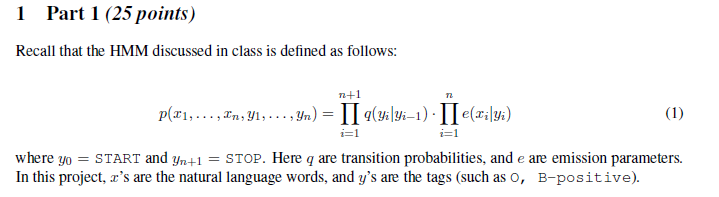

In [177]:
# Preprocessing
# Convert files to readable string list 
def get_all_text_tags(filename):
  with open(filename,'r') as f:
    text = f.readlines()

  all_text_tags = []

  # outputs a list of with 0th element as natural language word(x), 1st element as tag (O,B-Positive,...)(y)
  for i in text:
    new_text = i.replace("\n","") # remove trailing characters \n

    if new_text == ". .. O": # Handles the . .. issue for the russian training set. Need to find a better way to do this.
      inner_list = ['. ..', 'O']
      all_text_tags.append(inner_list)
    elif new_text ==". ... O":
      inner_list = ['. ...', 'O']
      all_text_tags.append(inner_list)
    else:
      inner_list = new_text.split(' ')
      all_text_tags.append(inner_list)
    

  return all_text_tags

RU_all_text_tags = get_all_text_tags('./RU/train')
ES_all_text_tags = get_all_text_tags('./ES/train')


tags_dict = {'O': 0, 'B-neutral' : 0 ,'B-positive' : 0,'B-negative' : 0,'I-neutral' : 0 ,'I-positive': 0,'I-negative': 0} # O, B-neutral, B-positive
### TODO:
# Not sure if need to account for the START STOP inside the emission params


def create_words_tag_dict(all_text_tags):
  words_tag_dict = {}
  new_tags_dict = tags_dict.copy()

  # add all words and their emission outputs to words_tag_dict
  # loop through all_words
  # then loop through all_text_tags to count the number of emissions from a certain word.
  # reset the dictionary for each word.
  for word in all_text_tags:
    if word[0] == '':
      continue
    words_tag_dict[word[0]] = tags_dict.copy()

  for i in range(len(all_text_tags)):
    if len(all_text_tags[i]) < 2:
      continue
    new_tags_dict[all_text_tags[i][1]] += 1 # Counting all the tags total in the training set
    if i == 0:
      # words_tag_dict[all_text_tags[i][0]]['START'] += 1 # Counting start for first word
      words_tag_dict[all_text_tags[i][0]][all_text_tags[i][1]] += 1 # Add in the actual implementation of the word
      # new_tags_dict['START'] += 1
    elif i == len(all_text_tags) - 1:
      # words_tag_dict[all_text_tags[i][0]]['STOP'] += 1 # Counting stop for last word
      words_tag_dict[all_text_tags[i][0]][all_text_tags[i][1]] += 1
      # new_tags_dict['STOP'] += 1
    else:
      words_tag_dict[all_text_tags[i][0]][all_text_tags[i][1]] += 1 # add other params to other items

  return words_tag_dict,new_tags_dict

RU_words_tag_dict,RU_tags_count = create_words_tag_dict(RU_all_text_tags)
ES_words_tag_dict,ES_tags_count = create_words_tag_dict(ES_all_text_tags)

print('ES_words_tag_dict:',ES_words_tag_dict)
print('ES_tags_count:',ES_tags_count)



ES_words_tag_dict: {'disfrutemos': {'O': 1, 'B-neutral': 0, 'B-positive': 0, 'B-negative': 0, 'I-neutral': 0, 'I-positive': 0, 'I-negative': 0}, 'de': {'O': 1091, 'B-neutral': 0, 'B-positive': 0, 'B-negative': 0, 'I-neutral': 7, 'I-positive': 73, 'I-negative': 41}, 'una': {'O': 238, 'B-neutral': 0, 'B-positive': 0, 'B-negative': 0, 'I-neutral': 0, 'I-positive': 1, 'I-negative': 0}, 'buenísima': {'O': 4, 'B-neutral': 0, 'B-positive': 0, 'B-negative': 0, 'I-neutral': 0, 'I-positive': 0, 'I-negative': 0}, 'calidad': {'O': 159, 'B-neutral': 0, 'B-positive': 5, 'B-negative': 2, 'I-neutral': 0, 'I-positive': 1, 'I-negative': 0}, 'en': {'O': 569, 'B-neutral': 0, 'B-positive': 0, 'B-negative': 0, 'I-neutral': 1, 'I-positive': 1, 'I-negative': 5}, 'el': {'O': 702, 'B-neutral': 0, 'B-positive': 0, 'B-negative': 0, 'I-neutral': 1, 'I-positive': 3, 'I-negative': 2}, 'producto': {'O': 3, 'B-neutral': 0, 'B-positive': 12, 'B-negative': 0, 'I-neutral': 0, 'I-positive': 0, 'I-negative': 0}, 'y': {'O':

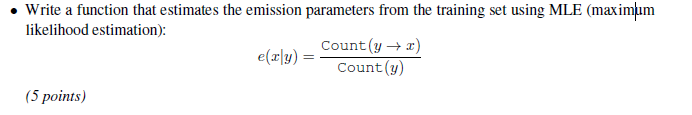

In [178]:
# 1a
# input x,y; output MLE of emission probability
def emission_MLE(x,y,words_tag_dict,tags_count):
  return words_tag_dict[x][y] / tags_count[y]

test_RU = emission_MLE('.','O',RU_words_tag_dict,RU_tags_count) # example, can loop through all the words in word list to find out 
print(test_RU)
test_ES = emission_MLE('disfrutemos','B-positive',ES_words_tag_dict,ES_tags_count)
print(test_ES)

0.05918458781362007
0.0


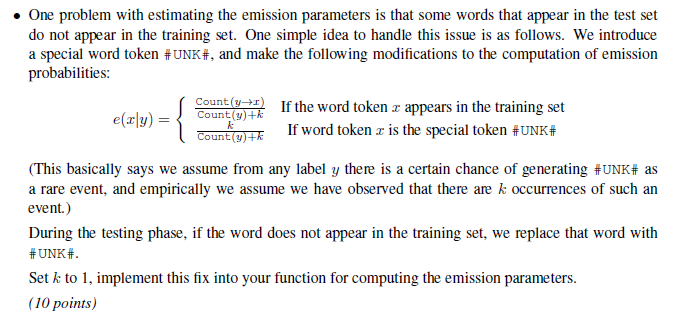

In [179]:
# 1b 
# same thing but add a condition if the word is NOT in words_tag_dict
# k is set to 1 


# for test have to loop through the test set and find the words not in words_tag_dict
def new_emission_MLE(x,y,words_tag_dict,tags_count,k=1):
  if x in words_tag_dict:
    return words_tag_dict[x][y] / (tags_count[y]+k)
  else:
    return k/(tags_count[y]+k)

test_new_RU = new_emission_MLE('.','O',RU_words_tag_dict,RU_tags_count)
print(test_new_RU)

0.05918326202370019


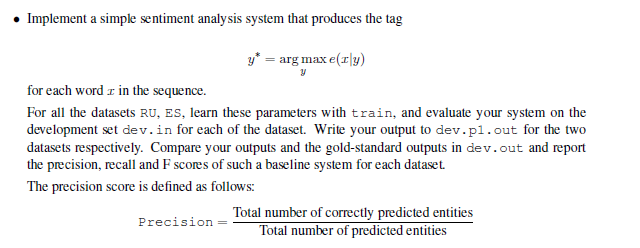

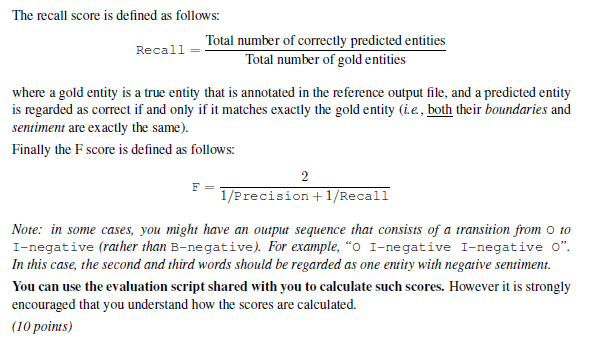

In [180]:
# 1c

# First we define the argmax function
def get_argmax(x,word_tags_dict,tags_count):
  max_prob_tag = '' # the assigned tag
  max_prob = 0 # the assigned tag probability
  for tag in tags_count:
    current_prob = new_emission_MLE(x,tag,word_tags_dict,tags_count)
    if current_prob > max_prob:
      max_prob = current_prob
      max_prob_tag = tag
  return max_prob_tag

RU_in_data = get_all_text_tags('./RU/dev.in')
ES_in_data = get_all_text_tags('./ES/dev.in')

# After that we define a function to convert to an output file
def get_pred_p1(in_data,word_tags_dict,tags_count,output_filename):
  for data in in_data:
    if data[0] == '':
      continue
    argmax = get_argmax(data[0],word_tags_dict,tags_count)
    data.append(argmax)
  
  all_string = '' #
  for item in in_data:
    all_string += ' '.join(item)
    all_string += '\n'
  
  with open(output_filename,'w') as f:
    f.write(all_string)

get_pred_p1(RU_in_data,RU_words_tag_dict,RU_tags_count,'./RU/dev.p1.out')
get_pred_p1(ES_in_data,ES_words_tag_dict,ES_tags_count,'./ES/dev.p1.out')

[['И'], ['что'], ['очень'], ['приятно'], ['-'], ['к'], ['шашлыку'], ['приносят'], ['тарелку'], ['с'], ['водой'], ['и'], ['лимоном'], ['для'], ['споласкивания'], ['рук'], [':'], ['я'], ['шашлык'], ['люблю'], ['есть'], ['руками'], ['.'], [''], ['Попробовали'], ['местное'], ['пиво'], ['–'], ['понравилось'], ['.'], [''], ['Возможно'], ['нам'], ['просто'], ['попался'], ['неприветливый'], ['официант'], [','], ['но'], ['и'], ['вид'], ['и'], ['манера'], ['говорить'], ['у'], ['него'], ['была'], ['отталкивающая'], ['.'], [''], ['Интерьер'], ['тоже'], ['поменялся'], [','], ['но'], ['не'], ['особо'], ['изменил'], ['своему'], ['стилю'], [','], ['обслуживание'], [','], ['как'], ['и'], ['раньше'], ['осталось'], ['на'], ['достаточно'], ['неплохом'], ['уровне'], [','], ['в'], ['общем'], ['мы'], ['остались'], ['довольны'], [','], ['спасибо'], ['!'], [''], ['Может'], ['персонал'], ['или'], ['руководство'], ['ресторанов'], ['все'], ['же'], ['читают'], ['отзывы'], ['и'], ['исправляются'], ['…'], ['На'], ['

In [181]:
# Evaluation for RU set

!python evalResult.py ./RU/dev.out ./RU/dev.p1.out


#Entity in gold data: 461
#Entity in prediction: 2089

#Correct Entity : 335
Entity  precision: 0.1604
Entity  recall: 0.7267
Entity  F: 0.2627

#Correct Sentiment : 136
Sentiment  precision: 0.0651
Sentiment  recall: 0.2950
Sentiment  F: 0.1067


In [182]:
# Evaluation for ES set

!python evalResult.py ./ES/dev.out ./ES/dev.p1.out


#Entity in gold data: 255
#Entity in prediction: 1734

#Correct Entity : 205
Entity  precision: 0.1182
Entity  recall: 0.8039
Entity  F: 0.2061

#Correct Sentiment : 112
Sentiment  precision: 0.0646
Sentiment  recall: 0.4392
Sentiment  F: 0.1126
